In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.utils
import torchvision
import torchvision.io

import _frameload

totensor = _frameload.totensor
topilimage = _frameload.topilimage
transform_forward = _frameload.transform_forward
transform_backward = _frameload.transform_backward

batch_size = 50


In [2]:
# get Files object so we can keep track of what's used, etc...
files = _frameload.FrameFiles()


In [3]:
# get training dataset, but DO NOT get testing dataset: too little memory for both
dataset_train = _frameload.Frame(files, 'train')


img     2622	 shape torch.Size([3, 384, 384]) 	 type photo
img     2267	 shape torch.Size([3, 384, 384]) 	 type anime
img     2467	 shape torch.Size([3, 384, 384]) 	 type photo
img     2539	 shape torch.Size([3, 384, 384]) 	 type photo


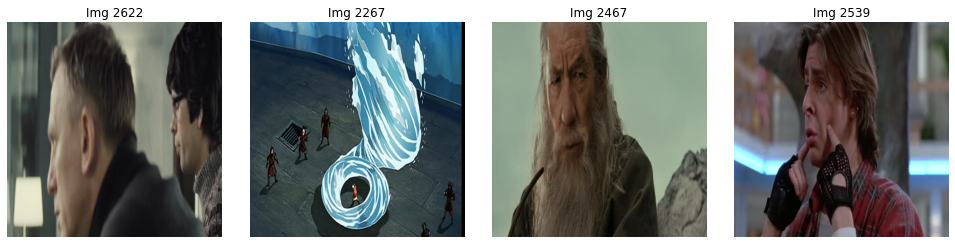

img     2294	 shape torch.Size([3, 384, 384]) 	 type photo
img     3807	 shape torch.Size([3, 384, 384]) 	 type photo
img     1761	 shape torch.Size([3, 384, 384]) 	 type photo
img     3648	 shape torch.Size([3, 384, 384]) 	 type photo


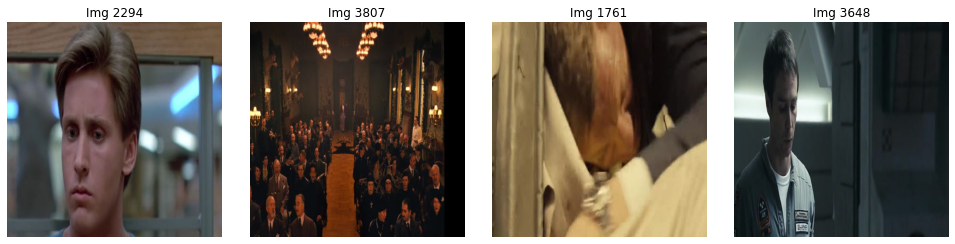

img     3504	 shape torch.Size([3, 384, 384]) 	 type anime
img     2817	 shape torch.Size([3, 384, 384]) 	 type anime
img     3080	 shape torch.Size([3, 384, 384]) 	 type photo
img      511	 shape torch.Size([3, 384, 384]) 	 type anime


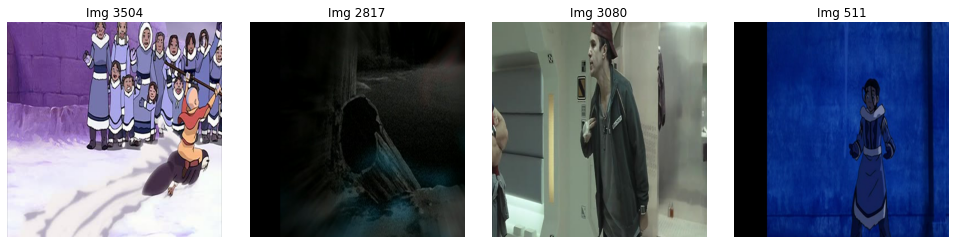

img     3684	 shape torch.Size([3, 384, 384]) 	 type photo
img     2634	 shape torch.Size([3, 384, 384]) 	 type photo
img      589	 shape torch.Size([3, 384, 384]) 	 type anime
img     1252	 shape torch.Size([3, 384, 384]) 	 type photo


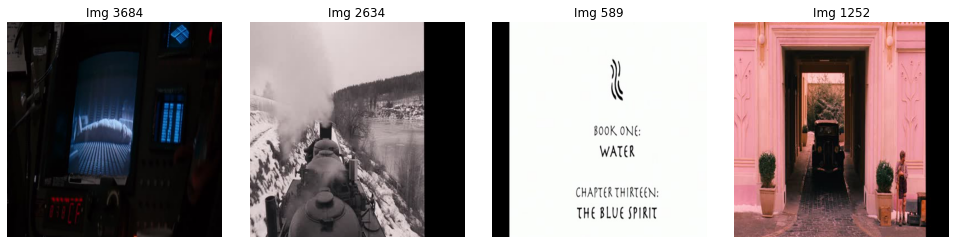

In [4]:
n_subplots = 4
figwidth = 14

def showRandom(d):
    fig, axes = plt.subplots(1, n_subplots, figsize=(figwidth, figwidth / n_subplots))
    for i, imgidx in enumerate(np.random.randint(0, len(d), n_subplots)):
        image, label = d[imgidx]
        print(f'img {imgidx:8d}\t', f'shape {str(image.shape):26s}\t',
              'type', 'anime' if label == 1 else 'photo')

        ax = axes[i]
        ax.imshow(transform_backward(image))
        ax.set_title(f'Img {imgidx}')
        ax.axis('off')

        plt.tight_layout()

    plt.show()


for _ in range(4):
    showRandom(dataset_train)


In [5]:
print(f'Training N photo:\t{np.sum(dataset_train.labels.numpy() == 0):8d}')
print(f'Training N anime:\t{np.sum(dataset_train.labels.numpy() == 1):8d}')
print(f'Training N:\t\t{len(dataset_train):8d}')


Training N photo:	    2000
Training N anime:	    2000
Training N:		    4000


In [6]:
class Vgg7Like(torch.nn.Module):
    """ Based on the VGG7 network found here: https://arxiv.org/pdf/1903.06379.pdf """
    
    def __init__(self):
        super().__init__()
        
        self.epoch = 0
        self.lr = 1e-3
        
        # pre-pool1
        self.conv1 = torch.nn.Conv2d(3, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 32, 3, 2)

        # pre-pool2
        self.conv3 = torch.nn.Conv2d(32, 64, 3, 1)
        self.conv4 = torch.nn.Conv2d(64, 64, 3, 2)
        self.conv5 = torch.nn.Conv2d(64, 64, 3, 2)
        self.conv6 = torch.nn.Conv2d(64, 32, 3, 2)  # I'm deviating here from VGG7 as described above

        self.fc1 = torch.nn.Linear(800, 1)
        
        self.activation = torch.nn.ReLU()
        self.pool = torch.nn.AvgPool2d(2, 2)
        self.sigmoidsharp = lambda x: torch.nn.ReLU6()(x * 6) / 6

    def forward(self, x):
        x.float()
        
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        
        # pool1
        # not sure if `x = self.activation(self.pool(x))` or `x = self.pool(x)`
        x = self.activation(self.pool(x))
        # x = self.pool(x)

        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.activation(self.conv5(x))
        x = self.activation(self.conv6(x))
        
        # pool2
        # again not sure if `x = self.activation(self.pool(x))` or `x = self.pool(x)`
        x = self.activation(self.pool(x))
        # x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        
        
        x = torch.squeeze(x)  # squeeze so output dims are correct
        x.float()
        return self.sigmoidsharp(x)

net = Vgg7Like().cuda()
net.float()  # to be extra sure

print(net)


Vgg7Like(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=800, out_features=1, bias=True)
  (activation): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


In [7]:
import torchinfo
torchinfo.summary(net, (batch_size, 3, 384, 384))


Layer (type:depth-idx)                   Output Shape              Param #
Vgg7Like                                 --                        --
├─Conv2d: 1-1                            [50, 32, 382, 382]        896
├─ReLU: 1-2                              [50, 32, 382, 382]        --
├─Conv2d: 1-3                            [50, 32, 190, 190]        9,248
├─ReLU: 1-4                              [50, 32, 190, 190]        --
├─AvgPool2d: 1-5                         [50, 32, 95, 95]          --
├─ReLU: 1-6                              [50, 32, 95, 95]          --
├─Conv2d: 1-7                            [50, 64, 93, 93]          18,496
├─ReLU: 1-8                              [50, 64, 93, 93]          --
├─Conv2d: 1-9                            [50, 64, 46, 46]          36,928
├─ReLU: 1-10                             [50, 64, 46, 46]          --
├─Conv2d: 1-11                           [50, 64, 22, 22]          36,928
├─ReLU: 1-12                             [50, 64, 22, 22]          --

In [8]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=net.lr, momentum=0.9)


In [9]:
print('Training...')

epsilon_train = 0.0001  # smaller than <epsilon_train> change in ratios of loss values

loss_last = 1000000000.
loss_this = 100000000.  # some number bigger than any possible loss
while loss_last / loss_this > 1 + epsilon_train:
    loss_last = loss_this
    loss_this = 0.
    net.epoch += 1

    for i, data in enumerate(torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()            
        optimizer.step()

        # print statistics
        loss_this += loss.item()
        # print(f'\tBatch {i:02d} loss: {loss.item():.2f}')
    print(f'Epoch {net.epoch:02d} loss: {loss_this:.3f}')
    dataset_train.refresh()

print('Finished training.')


Training...
Epoch 01 loss: 4000.000


RuntimeError: Found dtype Double but expected Float

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(loader_test):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = net(images)
        predictions = [1. if f >= 0.5 else 0. for f in outputs]
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct += 1
            total += 1
            
        if i > 10:
            break


# print accuracy for each class
print('correct', correct)
print('total', total)


In [ ]:
print(f'{correct / total * 100:03.1f}%')


In [ ]:
torch.save(net.state_dict(), os.path.join('model', f'{net._get_name()}_{datetime.datetime.now().strftime("%Y%m%dT%H%M")}.pth'))
